In [9]:
import numpy as np
from numpy.random import default_rng
from scipy.integrate import odeint
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [29]:
# Define classes
class Agent:
    def __init__(self, opinion, activity):
        self.x=opinion
        self.a=activity
        
    def setOpinion(self, opinion):
        self.x=opinion   
        
    def getOpinion(self):
        return self.x
    
    def setActivity(self, activity):
        self.a=activity
        
    def getActivity(self):
        return self.a
        
class Model:
    def __init__(self, N):
        
        x = np.linspace(-1,1,N)
        PowerDistribution = PowerLaw(a=epsilon)
        a = PowerDistribution.rvs(size=N)
        self.network = []
        for i in range(N):
            self.network.append(Agent(x[i], a[i]))

    def __init__(self, N, N_Influencer):
        
        # Initialise N common agents
        x = np.linspace(-1,1,N)
        PowerDistribution = PowerLaw(a=epsilon)
        a = PowerDistribution.rvs(size=N)
        self.network = []
        for i in range(N):
            self.network.append(Agent(x[i], a[i]))
        
        # Initialise N_Influencer influencer agents
        x = np.linspace(-1,1,N_Influencer)
        a = np.ones(N_Influencer)
        self.influencers = []
        for i in range(M):
            self.influencers.append(Agent(x[i], a[i]))
        
            
    def getNetwork(self):
        return self.network
    
    def getInfluencers(self):
        return self.influencers
    
    def getAllOpinions(self):
        allOpinions = np.zeros(len(self.network))
        for i in range(len(self.network)):
            allOpinions[i] = self.network[i].getOpinion()
        return allOpinions
    
    def getInfluencerOpinions(self):
        influencerOpinions = np.zeros(len(self.influencers))
        for i in range(len(self.influencers)):
            influencerOpinions[i] = self.influencers[i].getOpinion()
        return influencerOpinions
    
    def getAllActivities(self):
        allActivities = np.zeros(len(self.network))
        for i in range(len(self.network)):
            allActivities[i] = self.network[i].getActivity()
        return allActivities
    
    def getInfluencerActivities(self):
        influencerActivities = np.zeros(len(self.influencers))
        for i in range(len(self.influencers)):
            influencerActivities[i] = self.influencers[i].getActivity()
        return influencerActivities

    
    def updateAllOpinions(self, newOpinions):
        if len(self.network) == len(newOpinions):
            for i in range(len(self.network)):
                self.network[i].setOpinion(newOpinions[i])
    
    

class PowerLaw(rv_continuous):
    """Activitiy sampling distribution identical to Baumann et al.
    It models the intuitive assumption, that by far most people
    are hardly posting on social media, and even less people being
    very active. 
    

    For Reference, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous"""
    # define probability distribution as the paper's "F(a)"
    def _pdf(self, x):
        return ((1-gamma)/(1-epsilon**(1-gamma)))*x**(-1*gamma)


In [37]:
# Define methods
from timeit import default_timer

# Implement differential eq. 'dx/dt = [...]' as 'f(t) = [...]' 
def diffEq(x, t, alpha, K):
    #start = default_timer()
    N=len(x)
    sol = np.zeros(N)
    for index_i, i in enumerate(x):
        sum_tmp = 0
        for index_j, j in enumerate(x):
            #if A[i][j]==0: continue
            sum_tmp +=A[index_i][index_j]*np.tanh(alpha*j)
        sol[index_i] = -i+K*sum_tmp
    #print('diffEq: ')
    #print(default_timer() - start)
    return sol


def calculateProbabilities(i, j, x, beta):
    sum_tmp = 0
    for j_tmp in range(len(x)):
        if x[i] != x[j_tmp]:
            sum_tmp = sum_tmp+abs(x[i]-x[j_tmp])**(-beta)
    return (abs(x[i]-x[j])**(-beta))/sum_tmp

def generateContactMatrix(x, beta, m, r):
    #start = default_timer()
    rng = default_rng()
    A = np.zeros((len(x), len(x)))
    for index_i, i in enumerate(x):
        sum_tmp=0
        for j in x:
            if i==j: continue
            sum_tmp +=abs(i-j)**(-beta)
        
        for index_j, j in enumerate(x):
            if i==j: continue
            A[index_i][index_j] = (abs(i-j)**(-beta))/sum_tmp
            if m*A[index_i][index_j] > rng.random():
                A[index_i][index_j] = 1
                # Füge recipr. contacting ein:
                if r > rng.random():
                    A[index_j][index_i] = 1
    #print('Contact Matrix: ')
    #print(default_timer() - start)
    return A

def generateContactMatrix(model, N, beta, m, r):
    
    x = np.array(model.getAllOpinions())
    x = np.append(x, model.getInfluencerOpinions())
    a = np.array(model.getAllActivities())
    a = np.append(a, model.getInfluencerActivities())
    
    
    m_influencer = np.arange(m, N/2, len(x)-N)
    rng = default_rng()
    A = np.zeros((len(x), len(x)))
    for index_i, i in enumerate(x):
        if a[index_i] < rng.random(): continue
        
        sum_tmp=0
        for j in x:
            if i==j: continue
            sum_tmp +=abs(i-j)**(-beta)
        
        for index_j, j in enumerate(x):
            c = 0
            if i==j or A[index_i][index_j]==1: continue
            A[index_i][index_j] = (abs(i-j)**(-beta))/sum_tmp
            if index_j < N and m*A[index_i][index_j] > rng.random():
                A[index_i][index_j] = 1
                if r > rng.random():
                    A[index_j][index_i] = 1
            elif m_influencer[c]*A[index_i][index_j] > rng.random():
                c = c+1
                A[index_i][index_j] = 1
                # Füge recipr. contacting ein:
                if r > rng.random():
                    A[index_j][index_i] = 1
    #print('Contact Matrix: ')
    #print(default_timer() - start)
    return A

In [35]:
# Define fixed parameters
t_current = 0
tMax = 10
dt = 0.01
N = 100
N_Influencer = 10
K=3
# Define different alpha, beta values as arrays from which to pick for each graph
alphas = np.array([0.05, 3, 3])
betas = np.array([2, 0, 3])
alpha_current = alphas[0]
beta_current = betas[0]

# Fixed activity-driving (AD) parameters
m = 10
epsilon = 0.01
gamma = 2.1
r = 0.5


model = Model(N, N_Influencer)
opinionStorage = np.array(model.getAllOpinions())
opinionStorage = np.append(opinionStorage, model.getInfluencerOpinions())

[-1.         -0.97979798 -0.95959596 -0.93939394 -0.91919192 -0.8989899
 -0.87878788 -0.85858586 -0.83838384 -0.81818182 -0.7979798  -0.77777778
 -0.75757576 -0.73737374 -0.71717172 -0.6969697  -0.67676768 -0.65656566
 -0.63636364 -0.61616162 -0.5959596  -0.57575758 -0.55555556 -0.53535354
 -0.51515152 -0.49494949 -0.47474747 -0.45454545 -0.43434343 -0.41414141
 -0.39393939 -0.37373737 -0.35353535 -0.33333333 -0.31313131 -0.29292929
 -0.27272727 -0.25252525 -0.23232323 -0.21212121 -0.19191919 -0.17171717
 -0.15151515 -0.13131313 -0.11111111 -0.09090909 -0.07070707 -0.05050505
 -0.03030303 -0.01010101  0.01010101  0.03030303  0.05050505  0.07070707
  0.09090909  0.11111111  0.13131313  0.15151515  0.17171717  0.19191919
  0.21212121  0.23232323  0.25252525  0.27272727  0.29292929  0.31313131
  0.33333333  0.35353535  0.37373737  0.39393939  0.41414141  0.43434343
  0.45454545  0.47474747  0.49494949  0.51515152  0.53535354  0.55555556
  0.57575758  0.5959596   0.61616162  0.63636364  0.

In [ ]:
#xecution_start_time = time.time()
print('---\nModel started\n---\n')

# Integrate dynamics with 4th order Runge-Kutta (RK4)

for t in tqdm(np.arange(0, tMax, dt)):
    t_current = t_current + dt
    
    t_RK4 = np.linspace(t_current-dt, t_current, 2)
    A = generateContactMatrix(model, N, beta_current, m, r)
    currentOpinions = np.array(model.getAllOpinions())
    currentOpinions = np.append(currentOpinions, model.getInfluencerOpinions())
    solODE = odeint(diffEq, currentOpinions, t_RK4, args=(alpha_current, K))
    # Update and store new opinions in agents and storage array
    newOpinions = solODE[-1]
    model.updateAllOpinions(newOpinions[:N])
    #model.updateInflue
    opinionStorage = np.vstack([opinionStorage, newOpinions])

print('\n---\nModel finished\n---')
execution_end_time = time.time()
print('\n---\nTime needed:\t',execution_end_time-execution_start_time,'\n---')

---
Model started
---



  8%|▊         | 81/1000 [00:26<05:35,  2.74it/s]

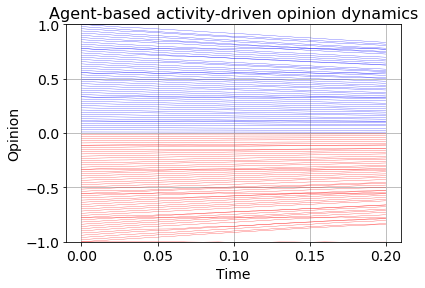

In [39]:
# Plot results:

# Globally change font size for Matplotlib plots
plt.rcParams.update({'font.size': 14})

# Get time values for plotting out of storage array information
time_finish = len(opinionStorage)*dt
time_0 = 0
times = np.arange(time_0, time_finish, dt)

# Plot each agent via looping over storage array
for i in range(len(opinionStorage.T)):
    # In case the last value of agent i is negative, the graph color will be changed to red 
    if opinionStorage.T[i][-1] < 0:
        color = 'r'
    else:
        color ='b'   
    plt.plot(times, opinionStorage.T[i], color, linewidth=.25)

plt.xlabel('Time')
plt.ylabel('Opinion')
plt.title('Agent-based activity-driven opinion dynamics', size=16)
plt.grid()
plt.ylim([-1, 1])
#plt.xticks([0, 5, 10])
#plt.yticks([-5, 0, 5])

# Uncomment if you do want to save the figure:
plot_name = 'Plot--N='+str(N)+'--alpha='+str(alpha_current)+'--beta='+str(beta_current)+'.png'
plt.savefig(plot_name)
plt.show()
